# Analyze User Behavior for The Company's Application

You work at a startup that sells food products. You need to analyze user behavior for the company's application.

First, study the sales funnel. Find out how users get to the purchase stage. Do users really get to this stage? How many are stuck in the previous phases? Which steps in particular?

Next, view the results of the A/A/B test. (Read on for more information on A/A/B testing). Designers would like to change the fonts of the entire app, but managers fear that users will find the new design intimidating. They decide to make the decision based on the results of an A/A/B test.

Users are divided into three groups: two control groups receive the old fonts and one test group receives the new ones. Find out which set of sources produces the best results.

The creation of two A groups has certain advantages. We can adapt a principle according to which we will only be confident in the accuracy of our tests when the two control groups are similar. If there are significant differences between the A groups, it can help us uncover factors that can skew the results. Comparing control groups also tells us how much time and data we'll need when running other tests.

You'll use the same dataset for general analysis and A/A/B analysis. In real projects, experiments are carried out constantly. Analysts study the quality of an application using general data, without paying attention to users' participation in experiments.

## Load data and prepare it for analysis

### Initialization

In [162]:
# Load the libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
from scipy.stats import fisher_exact
import seaborn as sns

### Load Data

In [163]:
# Laod data containing events actions
events_df = pd.read_csv("/datasets/logs_exp_us.csv", sep = '\t')
events_df.info(memory_usage='deep')
events_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 22.9 MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


### Rename Columns

In [164]:
# Renaming columns for convenience
events_df.rename(columns = {'EventName': 'event_name', 'DeviceIDHash': 'user_id',
                        'EventTimestamp': 'event_timestamp','ExpId': 'exp_id'}, inplace=True)
events_df

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


### Check for missing values and data types.

In [165]:
#Check for null-values
print(events_df.isna().sum())

#Checking datatype
print(events_df.dtypes)

# Convert event_timestamp to datetime
events_df['event_timestamp'] = pd.to_datetime(events_df['event_timestamp'], unit='s')
events_df.info()

event_name         0
user_id            0
event_timestamp    0
exp_id             0
dtype: int64
event_name         object
user_id             int64
event_timestamp     int64
exp_id              int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   user_id          244126 non-null  int64         
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   exp_id           244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


As we can see thre are no missing values in the data frame of events and the data type are corrct except for timestamp as we have changed it to datetime type

### Add a date and time column and a separate column for dates

In [166]:
# Add separate date and time columns
events_df['event_date'] = events_df['event_timestamp'].dt.date
events_df['event_time'] = events_df['event_timestamp'].dt.time
events_df

,event_name,user_id,event_timestamp,exp_id,event_date,event_time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,21:12:25
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,21:13:59
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,21:14:43
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,21:14:58


## Study and check the data

### How many events are in the logs?

In [167]:
# Count the number of events
total_events = events_df['event_name'].count()
print('Total number of events in the log equal', total_events)

Total number of events in the log equal 244126


### How many users are in the logs?

In [168]:
# Count the number of unique users
total_users = events_df['user_id'].nunique()
print('Total number of unique users in the log equal', total_users)

Total number of unique users in the log equal 7551


### What is the average number of events per user?

In [169]:
# Calculate the average number of events per user
average_events_per_user = total_events / total_users
print('The average number of events per user equal', average_events_per_user)

The average number of events per user equal 32.33028737915508


### What is the time period that the data covers?

#### Find the maximum and minimum dates. Draw a histogram by date and time.

In [170]:
# Determine the date range (min and max dates)
min_date = events_df['event_timestamp'].min()
max_date = events_df['event_timestamp'].max()

print('The minimum date equal', min_date)
print('The maximum date equal', max_date)

The minimum date equal 2019-07-25 04:43:36
The maximum date equal 2019-08-07 21:15:17


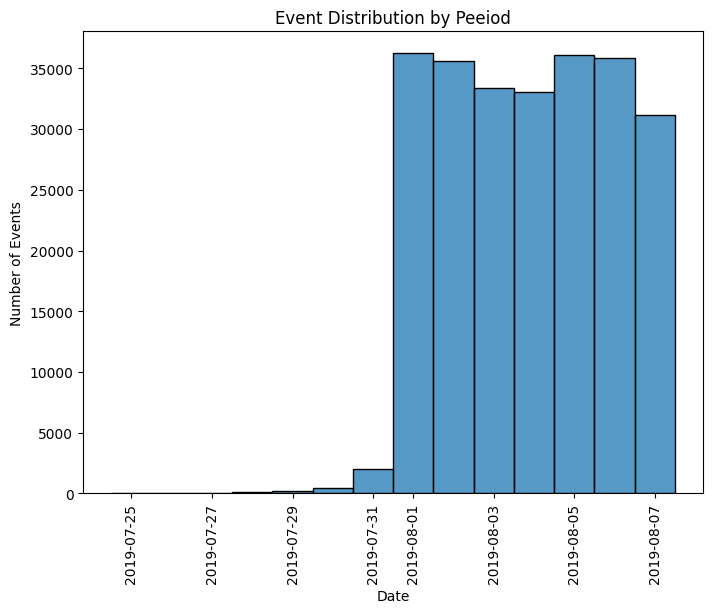

In [171]:
# Plot histogram for event dates
plt.figure(figsize=(8, 6))
sns.histplot(events_df['event_date'], bins=30)
plt.title('Event Distribution by Peeiod')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.xticks(rotation = 90)
plt.show()

As we can see most of the events started to happen during month of August 2019 with a little number during the end of July 2019

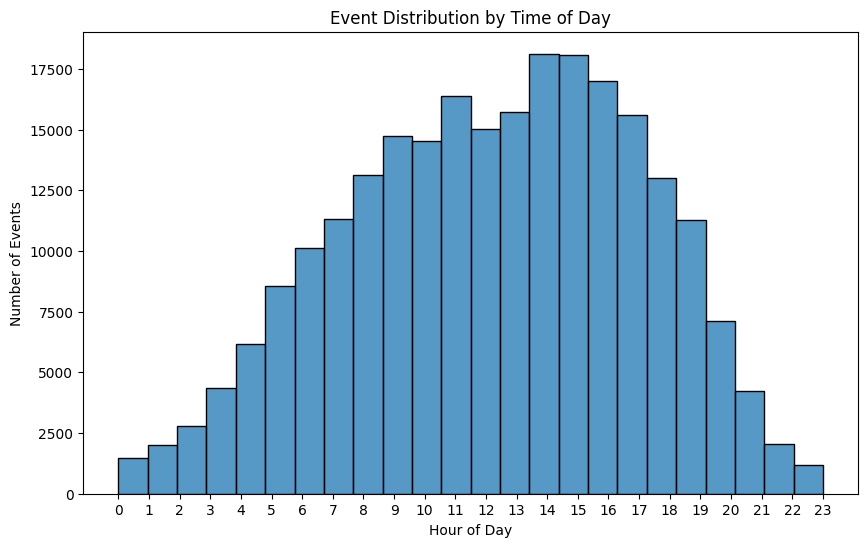

In [172]:
# Convert 'event_time' to hours for better histogram visualization
events_df['event_hour'] = pd.to_datetime(events_df['event_time'], format='%H:%M:%S').dt.hour

# Plot histogram for event times
plt.figure(figsize=(10, 6))
sns.histplot(events_df['event_hour'], bins=24, kde=False)
plt.title('Event Distribution by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events')
plt.xticks(range(0, 24))
plt.show()

All the hours of the day marked such a number of events with this number increase along the day to reach a peak in 14-15 o'clock afternoon, and starts to dcrease gradually witht the end of the day at noon

#### Can you be sure that you have the equally complete data for the entire period? Older events may end up appearing in some users' journals for technical reasons, and this can distort the overall picture. Find the moment when the data starts to be complete, and skip the previous section. What period does the data actually represent?

In [173]:
# Define the start of the complete data period (August 1, 2019)
complete_data_start_date = pd.Timestamp('2019-08-01')

# Filter the dataset to include only data from August 2019 onward
events_df_complete = events_df[events_df['event_timestamp'] >= complete_data_start_date]

# Verify the new date range
new_min_date = events_df_complete['event_timestamp'].min()
new_max_date = events_df_complete['event_timestamp'].max()

print('The complete data now represents the period from ', new_min_date,' to ', new_max_date)

The complete data now represents the period from  2019-08-01 00:07:28  to  2019-08-07 21:15:17


### Have you lost a lot of events and users when deleting the oldest data?

In [174]:
# Number of events and users after filtering
num_events_after = events_df_complete.shape[0]
num_users_after = events_df_complete['user_id'].nunique()

print('Number of events before filtering: ', total_events)
print('Number of users before filtering: ', total_users)
print('Number of events after filtering: ', num_events_after)
print('Number of users after filtering: ', num_users_after)

Number of events before filtering:  244126
Number of users before filtering:  7551
Number of events after filtering:  241298
Number of users after filtering:  7534


After deleting oldest data number of events has been decreased by 2828 to become 241298 and number of users has become 7534

### Make sure you have users from all three experimental groups.

In [175]:
# Check the presence of all experimental groups
exp_groups = events_df['exp_id'].unique()
print('Experimental groups present: ', exp_groups)

Experimental groups present:  [246 248 247]


## Study the event funnel

### See which events are in the journals and their frequency of occurrence. Sort them by frequency.

In [176]:
# Count the frequency of each event
event_frequencies = events_df_complete['event_name'].value_counts()

print(event_frequencies)

MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event_name, dtype: int64


There are 5 events with MainScreen having the most frequency followed by OffersScreen and CartScreen then PaymentScreen. Tutorial event shows a significant low frequency informing that this events wasn't applied too much

### Find the number of users who performed each of these actions. Sort the events by the number of users. Calculate the proportion of users who performed the action at least once.

In [177]:
# Count the number of unique users who ran each event
users_per_event = events_df_complete.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

# Calculate the proportion of users who ran each event at least once
total_users = events_df_complete['user_id'].nunique()
proportion_users_per_event = users_per_event / total_users

In [178]:
# Display the number of users and the ratio
event_analysis = pd.DataFrame({'users_count': users_per_event,'proportion': proportion_users_per_event})
print(event_analysis)

                         users_count  proportion
event_name                                      
MainScreenAppear                7419    0.984736
OffersScreenAppear              4593    0.609636
CartScreenAppear                3734    0.495620
PaymentScreenSuccessful         3539    0.469737
Tutorial                         840    0.111495


### In what order do you think the actions occurred? Are they all part of a single sequence? You don't need to take them into account when calculating the funnel.

In [179]:
# Sort data by user and timestamp
events_df_complete_sorted = events_df_complete.sort_values(by=['user_id', 'event_timestamp'])

events_df_complete_sorted

,event_name,user_id,event_timestamp,exp_id,event_date,event_time,event_hour
197263,MainScreenAppear,6888746892508752,2019-08-06 14:06:34,246,2019-08-06,14:06:34,14
209196,MainScreenAppear,6909561520679493,2019-08-06 18:52:54,247,2019-08-06,18:52:54,18
209199,PaymentScreenSuccessful,6909561520679493,2019-08-06 18:52:58,247,2019-08-06,18:52:58,18
209200,CartScreenAppear,6909561520679493,2019-08-06 18:52:58,247,2019-08-06,18:52:58,18
209201,MainScreenAppear,6909561520679493,2019-08-06 18:52:58,247,2019-08-06,18:52:58,18
...,...,...,...,...,...,...,...
221366,MainScreenAppear,9222603179720523844,2019-08-07 09:13:37,248,2019-08-07,09:13:37,9
221404,MainScreenAppear,9222603179720523844,2019-08-07 09:14:53,248,2019-08-07,09:14:53,9
221406,MainScreenAppear,9222603179720523844,2019-08-07 09:15:01,248,2019-08-07,09:15:01,9
221412,MainScreenAppear,9222603179720523844,2019-08-07 09:15:13,248,2019-08-07,09:15:13,9


In [180]:
# Get the sequence of events per user
user_event_sequences = events_df_complete_sorted.groupby('user_id')['event_name'].apply(lambda x: list(x))
user_event_sequences.sample(10)

user_id
8904648979022564504    [MainScreenAppear, OffersScreenAppear, MainScr...
3157721013859307056    [MainScreenAppear, CartScreenAppear, PaymentSc...
7005791568193762129    [Tutorial, MainScreenAppear, OffersScreenAppea...
6355882190390085010    [MainScreenAppear, MainScreenAppear, MainScree...
3665255445988174819    [MainScreenAppear, MainScreenAppear, MainScree...
3569490596734872842    [MainScreenAppear, OffersScreenAppear, OffersS...
5609174282068681071    [MainScreenAppear, OffersScreenAppear, Payment...
8162308900885925073    [MainScreenAppear, MainScreenAppear, MainScree...
424826562612017366     [MainScreenAppear, OffersScreenAppear, OffersS...
378761015309962378     [Tutorial, MainScreenAppear, OffersScreenAppea...
Name: event_name, dtype: object

The main order of events must be in a sequence as MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful. Tutorial could occur at various points, not necessarily in sequence with the other events

We can conclude after the analysis that the events doesn't occur in a single sequence for all users. As some users starts with the mainscreen events moving to the cartscreen event then paymentscreen; while other users starts from the tutorial and move to the offerscreen, and others start with offersscreen and continue in the same event then move to mainscreen event

### Use the event funnel to find the proportion of users who move from one stage to the next (for example, for event sequence A → B → C, calculate the ratio of users in step B to the number of users in step A, and the ratio of users in step C to the number in step B).

In [181]:
# Number of users who held their first event
users_event_A = events_df_complete_sorted[events_df_complete_sorted['event_name'] == 'MainScreenAppear']['user_id'].nunique()
print('Users who performed MainScreenAppear event: ', users_event_A)

Users who performed MainScreenAppear event:  7419


In [182]:
# Number of users who performed the second event
users_event_B = events_df_complete_sorted[events_df_complete_sorted['event_name'] == 'OffersScreenAppear']['user_id'].nunique()
conversion_A_to_B = users_event_B / users_event_A

print('Users who performed OffersScreenAppear event: ', users_event_B)
print(f'Conversion rate from MainScreenAppear to OffersScreenAppear: {conversion_A_to_B:.2%}')

Users who performed OffersScreenAppear event:  4593
Conversion rate from MainScreenAppear to OffersScreenAppear: 61.91%


In [183]:
# Number of users who held the third event
users_event_C = events_df_complete_sorted[events_df_complete_sorted['event_name'] == 'CartScreenAppear']['user_id'].nunique()
conversion_B_to_C = users_event_C / users_event_B

print('Users who performed CartScreenAppear event: ', users_event_C)
print(f'Conversion rate from OffersScreenAppear to CartScreenAppear:  {conversion_B_to_C:.2%}')

Users who performed CartScreenAppear event:  3734
Conversion rate from OffersScreenAppear to CartScreenAppear:  81.30%


In [184]:
# Number of users who held the fourth event
users_event_D = events_df_complete_sorted[events_df_complete_sorted['event_name'] == 'PaymentScreenSuccessful']['user_id'].nunique()
conversion_C_to_D = users_event_D / users_event_C

print('Users who performed event PaymentScreenSuccessful: ', users_event_D)
print(f'Conversion rate from CartScreenAppear to PaymentScreenSuccessful: {conversion_C_to_D:.2%}')

Users who performed event PaymentScreenSuccessful:  3539
Conversion rate from CartScreenAppear to PaymentScreenSuccessful: 94.78%


### In which phase do you lose the most users?

In [185]:
# Calculate user losses in each transition
drop_A_to_B = 1 - conversion_A_to_B
drop_B_to_C = 1 - conversion_B_to_C
drop_C_to_D = 1 - conversion_C_to_D

print(f'Loss of users from MainScreenAppear to OffersScreenAppear: {drop_A_to_B:.2%}')
print(f'Loss of users from OffersScreenAppear to CartScreenAppear: {drop_B_to_C:.2%}')
print(f'Loss of CartScreenAppear users to PaymentScreenSuccessful: {drop_C_to_D:.2%}')

Loss of users from MainScreenAppear to OffersScreenAppear: 38.09%
Loss of users from OffersScreenAppear to CartScreenAppear: 18.70%
Loss of CartScreenAppear users to PaymentScreenSuccessful: 5.22%


### What is the share of users who go the entire way, from the first event to the payment?

In [186]:
funnel_completion_rate = users_event_D / users_event_A
print(f'Share of users completing the funnel: {funnel_completion_rate:.2%}')

Share of users completing the funnel: 47.70%


The sales funnel analysis reveals that while 47.7% of users complete the purchase process, there is a significant drop-off of 38.09% between the main screen and the offers screen. However, users who reach the offers screen show strong intent, with 81.3% moving to the cart and 94.78% completing their purchase. Improving the initial engagement on the main screen could enhance overall conversion rates, while maintaining the streamlined process from cart to payment will help sustain high completion rates.

## Study the results of the experiment

### How many users are in each group?

In [203]:
# Count the number of users at each group
users_per_group = events_df_complete.groupby('exp_id')['user_id'].nunique().sort_values(ascending=False)
users_per_group 

exp_id
248    2537
247    2513
246    2484
Name: user_id, dtype: int64

We can see that test group 248 has more users 2537 than control groups 247 (2513 users) and 246 (2484 users)

### We have two control groups in A/A testing, in which we check our mechanisms and calculations. See if there is a statistically significant difference between the 246 and 247 samplings.

In [204]:
# Calculate the percentage of users in each control group with respect to the total users
users_percentage_246 = users_per_group[246]/users_per_group.sum() *100
print('Percentage of users of group 246: ', users_percentage_246)

users_percentage_247 = users_per_group[247]/users_per_group.sum() *100
print('Percentage of users of group 247: ', users_percentage_247)

print('Difference of users between two control groups: ', users_percentage_247 - users_percentage_246,'%')

Percentage of users of group 246:  32.97053358109901
Percentage of users of group 247:  33.35545526944518
Difference of users between two control groups:  0.3849216883461679 %


The difference between users of group 246 and 247 is 0.38% less than 1%.
Which means that there is no statistically significant difference between the 246 and 247 samplings.

### Select the most popular event. In each of the control groups, find the number of users who performed this action. Find their ratio. Check if the difference between the groups is statistically significant. Repeat the procedure for all other events (it will save time if you create a special function for this test). Can you confirm that the groups were divided correctly?

In [205]:
# Count the number of users for each event in each group
event_counts = events_df_complete_sorted[events_df_complete_sorted['exp_id'].isin([246, 247])].groupby(['exp_id', 'event_name'])['user_id'].nunique().unstack()
most_popular_event = event_counts.sum().idxmax()
print(f'The most popular event is: {most_popular_event}')

# Count the number of unique users who performed the most popular event in each control group
group_246_count = events_df_complete_sorted[(events_df_complete_sorted['exp_id'] == 246) & (events_df_complete_sorted['event_name'] == most_popular_event)]['user_id'].nunique()
group_247_count = events_df_complete_sorted[(events_df_complete_sorted['exp_id'] == 247) & (events_df_complete_sorted['event_name'] == most_popular_event)]['user_id'].nunique()

# Calculate the proportions
proportion_246 = group_246_count / users_per_group[246]
proportion_247 = group_247_count / users_per_group[247]

print(f'Proportion of users in group 246 who performed {most_popular_event}: {proportion_246:.4f}')
print(f'Proportion of users in group 247 who performed {most_popular_event}: {proportion_247:.4f}')

ValueError: attempt to get argmax of an empty sequence

In [206]:
#Let's use Fisher's exact test to see if the difference between the proportions of the control groups is statistically significant.
# Create the contingency table
contingency_table = [[group_246_count, users_per_group[246] - group_246_count],
                    [group_247_count, users_per_group[247] - group_247_count]
                        ]

alpha = 0.05
# Calculate the p-value using Fisher's exact test
_, p_value = fisher_exact(contingency_table)

print(f'P-value between groups 246 and 247 for event {most_popular_event}: {p_value:.4f}')

if (p_value < alpha): # compare p-value with the significance level alpha
    print("Reject Null Hypothesis")
else:
    print("Cannot reject the Null Hypothesis")

P-value between groups 246 and 247 for event MainScreenAppear: 0.8115
Cannot reject the Null Hypothesis


In [207]:
#Create a function to repeat the above process for all events.

def compare_events(data, event_name, group1, group2):
    # Count the number of users who held the event in each group
    group1_count = data[(data['exp_id'] == group1) & (data['event_name'] == event_name)]['user_id'].nunique()
    group2_count = data[(data['exp_id'] == group2) & (data['event_name'] == event_name)]['user_id'].nunique()
    
     # Total number of users in each group
    group1_total = users_per_group[group1]
    group2_total = users_per_group[group2]
    
   
    # Calculate the proportions
    proportion1 = group1_count / group1_total
    proportion2 = group2_count / group2_total

    # Fisher's exact test
    contingency_table = [
        [group1_count, group1_total - group1_count],
        [group2_count, group2_total - group2_count]
    ]
    _, p_value = fisher_exact(contingency_table)
    
    return proportion1, proportion2, p_value

# Apply the function to all events
events = events_df_complete_sorted['event_name'].unique()
results = {}

for event in events:
    proportion246, proportion247, p_value = compare_events(events_df_complete_sorted, event, 246, 247)
    results[event] = {
        'Proportion_246': proportion246,
        'Proportion_247': proportion247,
        'P-value': p_value
    }

alpha = 0.05
# Display the results
for event, result in results.items():
    print(f"Event: {event}")
    print(f" Proportion in group 246: {result['Proportion_246']:.4f}")
    print(f" Proportion in group 247: {result['Proportion_247']:.4f}")
    print(f"  P-value: {result['P-value']:.4f}")

    if (p_value < alpha): # compare p-value with the significance level alpha
        print("Reject Null Hypothesis")
    else:
        print("Cannot reject the Null Hypothesis")
    print()

Event: MainScreenAppear
 Proportion in group 246: 0.0000
 Proportion in group 247: 0.0000
  P-value: 1.0000
Cannot reject the Null Hypothesis

Event: PaymentScreenSuccessful
 Proportion in group 246: 0.0000
 Proportion in group 247: 0.0000
  P-value: 1.0000
Cannot reject the Null Hypothesis

Event: CartScreenAppear
 Proportion in group 246: 0.0000
 Proportion in group 247: 0.0000
  P-value: 1.0000
Cannot reject the Null Hypothesis

Event: OffersScreenAppear
 Proportion in group 246: 0.0000
 Proportion in group 247: 0.0000
  P-value: 1.0000
Cannot reject the Null Hypothesis

Event: Tutorial
 Proportion in group 246: 0.0000
 Proportion in group 247: 0.0000
  P-value: 1.0000
Cannot reject the Null Hypothesis



After testing and getting the p_value we have concluded that Null Hypothesis cannot be rejected.

This means that there is no statistically significant difference between the 246 and 247 samplings with respect to the most popuar events MainScreenAppear and also all other events, confriming that the groups were divided correctly.

### Do the same thing for the group with changed fonts. Compare the results with those of each of the control groups for each event separately. Compare the results with the combined results for the control groups. What conclusions can you draw from the experiment?

In [208]:
# Compare group 248 with group 246
results_248_vs_246 = {}

for event in events:
    proportion248, proportion246, p_value = compare_events(events_df_complete_sorted, event, 248, 246)
    results_248_vs_246[event] = {
        'Proportion_248': proportion248,
        'Proportion_246': proportion246,
        'P-value': p_value
    }

# Compare group 248 with group 247
results_248_vs_247 = {}

for event in events:
    proportion248, proportion247, p_value = compare_events(events_df_complete_sorted, event, 248, 247)
    results_248_vs_247[event] = {
        'Proportion_248': proportion248,
        'Proportion_247': proportion247,
        'P-value': p_value
    }
    
# Display the results for group 248 vs. 246
print("Comparison of group 248 with group 246:")
print('----------------------------------------')

for event, result in results_248_vs_246.items():
    print(f"Event: {event}")
    print(f" Proportion in group 248: {result['Proportion_248']:.4f}")
    print(f" Proportion in group 246: {result['Proportion_246']:.4f}")
    print(f"  P-value: {result['P-value']:.4f}")
    
    if result['P-value'] < alpha:
        print("Reject Null Hypothesis")
    else:
        print("Cannot reject the Null Hypothesis")
    print()

# Display the results for group 248 vs. 247
print('........................................')
print("Comparison of group 248 with group 247:")
print('----------------------------------------')

for event, result in results_248_vs_247.items():
    print(f"Event: {event}")
    print(f" Proportion in group 248: {result['Proportion_248']:.4f}")
    print(f" Proportion in group 247: {result['Proportion_247']:.4f}")
    print(f"  P-value: {result['P-value']:.4f}")

    if result['P-value'] < alpha:
        print("Reject Null Hypothesis")
    else:
        print("Cannot reject the Null Hypothesis")
    print()

Comparison of group 248 with group 246:
----------------------------------------
Event: MainScreenAppear
 Proportion in group 248: 0.9827
 Proportion in group 246: 0.0000
  P-value: 0.0000
Reject Null Hypothesis

Event: PaymentScreenSuccessful
 Proportion in group 248: 0.4655
 Proportion in group 246: 0.0000
  P-value: 0.0000
Reject Null Hypothesis

Event: CartScreenAppear
 Proportion in group 248: 0.4848
 Proportion in group 246: 0.0000
  P-value: 0.0000
Reject Null Hypothesis

Event: OffersScreenAppear
 Proportion in group 248: 0.6035
 Proportion in group 246: 0.0000
  P-value: 0.0000
Reject Null Hypothesis

Event: Tutorial
 Proportion in group 248: 0.1100
 Proportion in group 246: 0.0000
  P-value: 0.0000
Reject Null Hypothesis

........................................
Comparison of group 248 with group 247:
----------------------------------------
Event: MainScreenAppear
 Proportion in group 248: 0.9827
 Proportion in group 247: 0.0000
  P-value: 0.0000
Reject Null Hypothesis

Even

After testing and getting the p_value we have concluded that Null Hypothesis cannot be rejected.

This means that there is no statistically significant difference between the Group 248 with changed fonts and each of the Control Group 246 & 247 (by testing all events), confriming that the groups were divided correctly.

In [213]:
# Combine users for groups 246 and 247 for each event

# Add a new entry for the combined control group (246 and 247)
users_per_group[2467] = users_per_group[246] + users_per_group[247]

# Create a copy of the original DataFrame
events_df_complete_copy = events_df_complete_sorted.copy()

# Update the exp_id values for 246 and 247 in the copy
events_df_complete_copy.loc[events_df_complete_copy['exp_id'].isin([246, 247]), 'exp_id'] = 2467

# Verify the changes
print(events_df_complete_sorted['exp_id'].value_counts())
print()

# Compare group 248 with the combined control group
results_248_vs_combined = {}
for event in events:
    proportion248, proportion2467, p_value = compare_events(events_df_complete_copy, event, 248, 2467)
    results_248_vs_combined[event] = {
        'Proportion_248': proportion248,
        'Proportion_Control_Combined': proportion2467,
        'P-value': p_value
    }

# Display the results for group 248 vs. combined control
print("Comparison of group 248 with combined control group:")
print('----------------------------------------')

for event, result in results_248_vs_combined.items():
    print(f"Event: {event}")
    print(f" Proportion in group 248: {result['Proportion_248']:.4f}")
    print(f" Proportion in combined control: {result['Proportion_Control_Combined']:.4f}")
    print(f"  P-value: {result['P-value']:.4f}")

    if result['P-value'] < alpha:
        print("Reject Null Hypothesis")
    else:
        print("Cannot reject the Null Hypothesis")
    print()

2467    156572
248      84726
Name: exp_id, dtype: int64

Comparison of group 248 with combined control group:
----------------------------------------
Event: MainScreenAppear
 Proportion in group 248: 0.9827
 Proportion in combined control: 0.9858
  P-value: 0.3201
Cannot reject the Null Hypothesis

Event: PaymentScreenSuccessful
 Proportion in group 248: 0.4655
 Proportion in combined control: 0.4719
  P-value: 0.6081
Cannot reject the Null Hypothesis

Event: CartScreenAppear
 Proportion in group 248: 0.4848
 Proportion in combined control: 0.5011
  P-value: 0.1880
Cannot reject the Null Hypothesis

Event: OffersScreenAppear
 Proportion in group 248: 0.6035
 Proportion in combined control: 0.6128
  P-value: 0.4387
Cannot reject the Null Hypothesis

Event: Tutorial
 Proportion in group 248: 0.1100
 Proportion in combined control: 0.1123
  P-value: 0.7864
Cannot reject the Null Hypothesis



By combining both groups and applying the tests, we can conclude from the p_values resulted that Null Hypothesis cannot be rejected.

This means that there is no statistically significant difference between Group 248 with changed fonts and boht Control Group 246 & 247 combined (by testing all events), confirming that the division was performed correctly.

### What level of significance have you set to test the statistical hypotheses mentioned above? Calculate how many statistical hypothesis tests you have performed. With a statistical significance level of 0.1, one out of every 10 results may be false. What should be the level of significance? If you want to change it, perform the previous steps again and check your conclusions.

For each event, 3 hypothesis tests were performed: 248 vs 246, 248 vs 247, 248 vs combined control.
We have 5 main events MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial

Therefore, with 5 events and 3 comparisons per event: 5 * 3 = 15 hypothesis tests

In [214]:
# Initial significance level
alpha = 0.05

# Number of tests performed
num_tests = 15

# Significance level adjusted with Bonferroni
adjusted_alpha = alpha / num_tests
print(f"Adjusted significance level: {adjusted_alpha:.4f}")

Adjusted significance level: 0.0033


As the adjusted alpha is less than the main significance value, this means that the analysis still same regarding the statistically significant difference between groups (no difference)

In [215]:
#Change Significance level
alpha = 0.1

# Number of tests performed
num_tests = 15

# Significance level adjusted with Bonferroni
adjusted_alpha = alpha / num_tests
print(f"Adjusted significance level: {adjusted_alpha:.4f}")

Adjusted significance level: 0.0067


Althought we chose a higher signifcance level 0.1 which increases the chance of false positives the p_values still greater than the adjusted significance level resulted based on the number of tests performed and our previous analaysis continues valid.